In [1]:
from utils import load_cnf, cnf_to_bqm

In [2]:
folder = 'sat'
_variables = 140
path = f"./{folder}/sgen1-{folder}-{_variables}-100.cnf"
num_variables, num_clauses, variables, clauses = load_cnf(path)
bqm, or_result_vars, clauses_qubits = cnf_to_bqm(variables, clauses)

In [3]:
len(bqm.adj)

308

In [26]:
import neal

simulated_sampler = neal.SimulatedAnnealingSampler()
simulated_sample = simulated_sampler.sample(bqm)
simulated_sample.first.energy

8.0

In [4]:
import dimod 
import networkx as nx
from matplotlib.pyplot import figure

In [5]:
bqm_graph = dimod.to_networkx_graph(bqm)

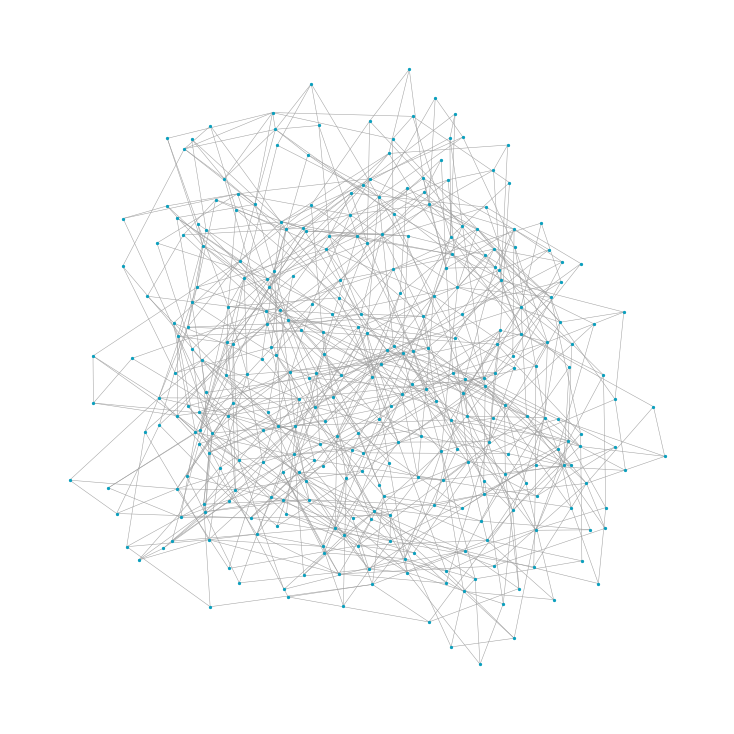

In [6]:
figure(figsize=(10, 10))
nx.draw(bqm_graph,node_size=5, width=0.5, node_color='#0a9fbd', edge_color="#9e9e9e")

# Preprocessing

In [7]:
from dwave.preprocessing.lower_bounds import roof_duality
roof_duality(bqm)

(-168.0, {})

In [8]:
from minorminer import find_embedding
from dwave.system import DWaveSampler, FixedEmbeddingComposite
qpu_pegasus = DWaveSampler(solver={'topology__type': 'pegasus'})

In [14]:
embedding = find_embedding(bqm.quadratic.keys(), qpu_pegasus.edgelist, random_seed=1)

In [15]:
def get_chain_lengths(_embedding):
    lengths = []
    biases = []
    for (key, value) in _embedding.items():
        lengths.append(len(value))
        biases.append(bqm.linear[key])
    return lengths, biases
        

In [16]:
import seaborn as sns

<AxesSubplot:ylabel='Count'>

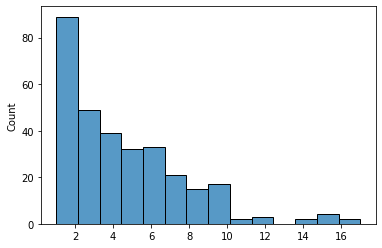

In [17]:
sns.histplot(get_chain_lengths(embedding)[0])

<AxesSubplot:ylabel='Count'>

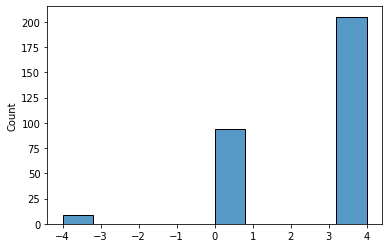

In [18]:
sns.histplot(get_chain_lengths(embedding)[1])

In [25]:
sampler = FixedEmbeddingComposite(DWaveSampler(solver={"name": "Advantage_system4.1"}), embedding)

In [50]:
sampleset = sampler.sample(bqm, num_reads=1000, answer_mode='raw')

In [51]:
sampleset.first.energy

34.0

In [32]:
sampleset = sampler.sample(bqm, num_reads=5000, answer_mode='raw', chain_strength=2)
sampleset.first.energy

24.0

In [34]:
sampleset = sampler.sample(bqm, num_reads=5000, answer_mode='raw', chain_strength=2, num_spin_reversal_transforms=2)
sampleset.first.energy

22.0

In [72]:
anneal_offsets = [0]*qpu_pegasus.properties['num_qubits']

for (key, chains) in embedding.items():
        if len(chains) > 7:
            for qubit in chains:
                anneal_offsets[qubit] = 0.0
        else:
            for qubit in chains:
                anneal_offsets[qubit] = 0.1
            

In [73]:
sampleset = sampler.sample(bqm, num_reads=5000, answer_mode='raw', anneal_offsets=anneal_offsets)
sampleset.first.energy

36.0

In [74]:
qpu_qubits_used = set()
for (key, chains) in embedding.items():
    for qubit in chains:
        qpu_qubits_used.add(qubit)
        
len(qpu_qubits_used)

1413